In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/demand-prediction'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/demand-prediction/extended_fmcg_demand_forecasting.csv


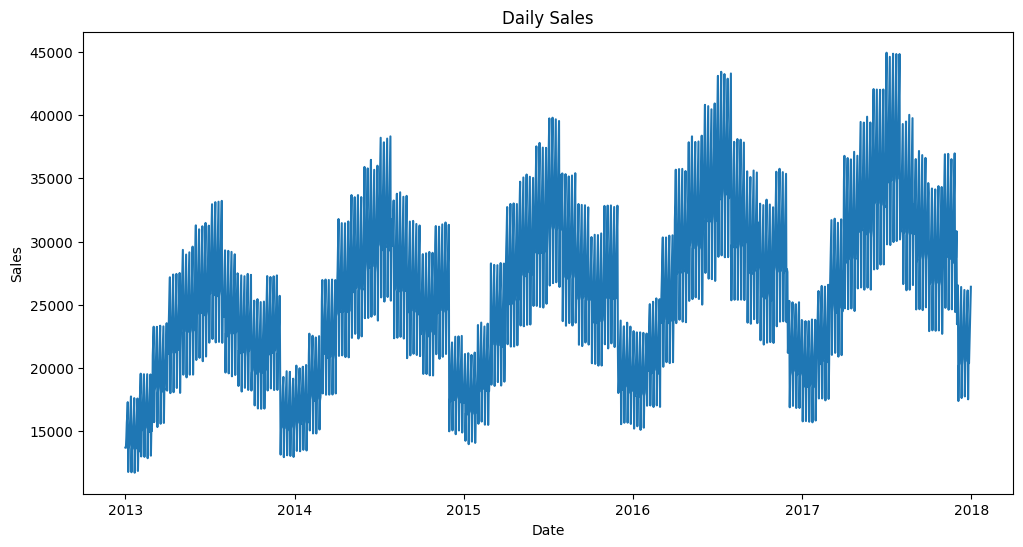

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.1262 - val_loss: 0.0168
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0133 - val_loss: 0.0166
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0124 - val_loss: 0.0161
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0128 - val_loss: 0.0163
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0126 - val_loss: 0.0166
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0124 - val_loss: 0.0166
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0118 - val_loss: 0.0157
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0112 - val_loss: 0.0159
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0117 - val_loss: 0.0157
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0116 - val_loss: 0.0169
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0118 - val_loss: 0.0156
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0

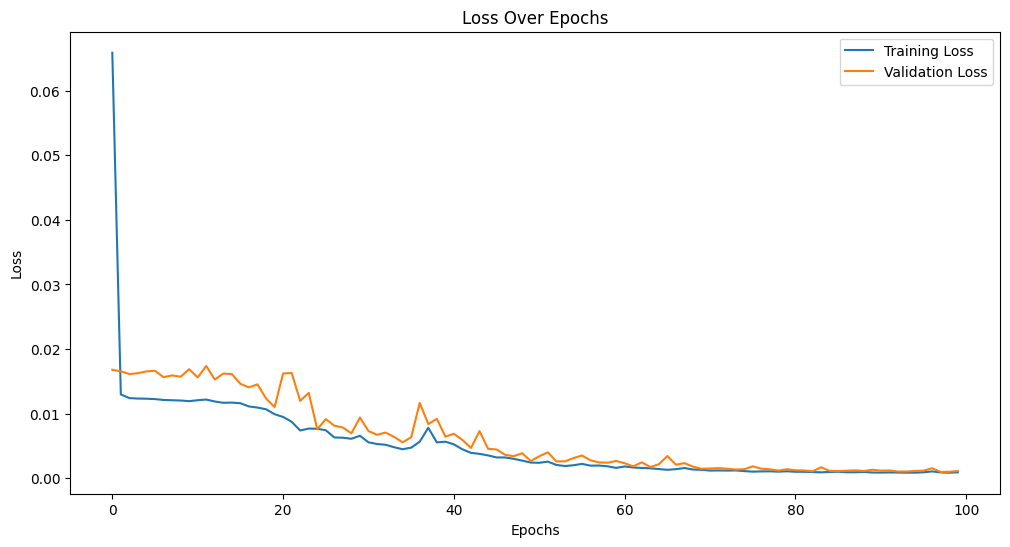

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


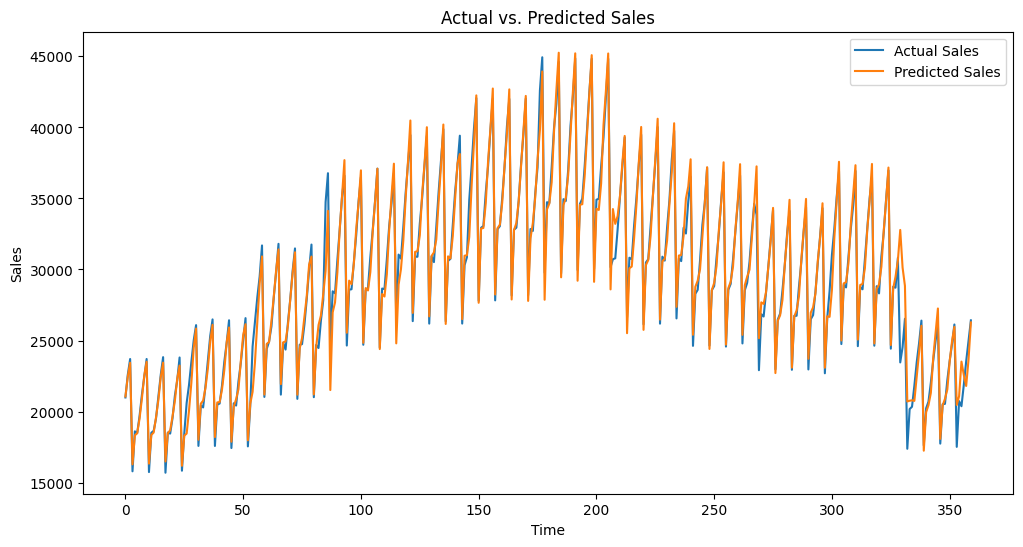

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
data = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/train.csv', parse_dates=['date'])

# Aggregate sales data by date
daily_sales = data.groupby('date').sum().reset_index()

# Visualize the sales data
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['date'], daily_sales['sales'])
plt.title('Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Normalize the sales data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_sales = scaler.fit_transform(daily_sales['sales'].values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 30  # Use the past 30 days to predict the next day's sales
X, y = create_sequences(scaled_sales, SEQ_LENGTH)

# Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

# Plot actual vs. predicted sales
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Sales')
plt.plot(predictions, label='Predicted Sales')
plt.title('Actual vs. Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()


First few rows of the synthetic data:
        Date Product_Category       Product_Name  Sales_Volume  Price  \
0 2020-01-01     Frozen Foods  Frozen Vegetables           216    180   
1 2020-01-01     Frozen Foods  Frozen Vegetables           299    180   
2 2020-01-01           Snacks              Chips           232     30   
3 2020-01-01        Household       Toilet Paper           215     60   
4 2020-01-01        Household                Mop           255    300   

   Promotion Store_Location  Weekday  Supplier_Cost  Replenishment_Lead_Time  \
0          1        Kothrud        2     157.053126                        1   
1          0  Koregaon Park        2     142.611886                        3   
2          0        Kothrud        2      20.005293                        6   
3          0        Kothrud        2      41.076515                        1   
4          0        Kothrud        2     187.161567                        4   

   Stock_Level  
0          163  
1       

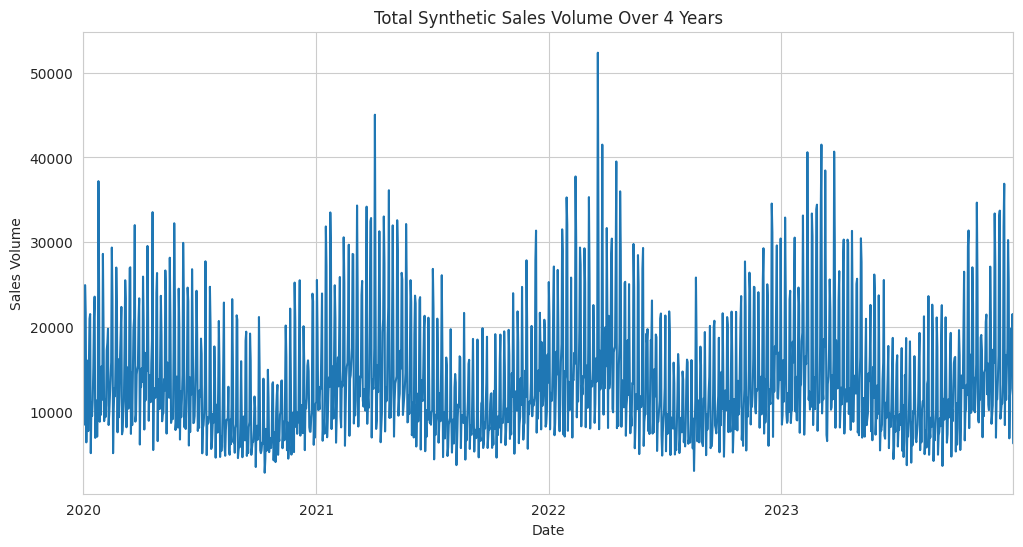

<ipython-input-60-3765441f2eff>:179: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[193.20909826 188.70900863 184.04559478 ... 324.57612236 172.07593454
 381.22417888]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_noisy.loc[category_mask, 'Price'] = df_noisy.loc[category_mask, 'Price'] * (1 + np.random.normal(0, noise_factor, category_mask.sum()))


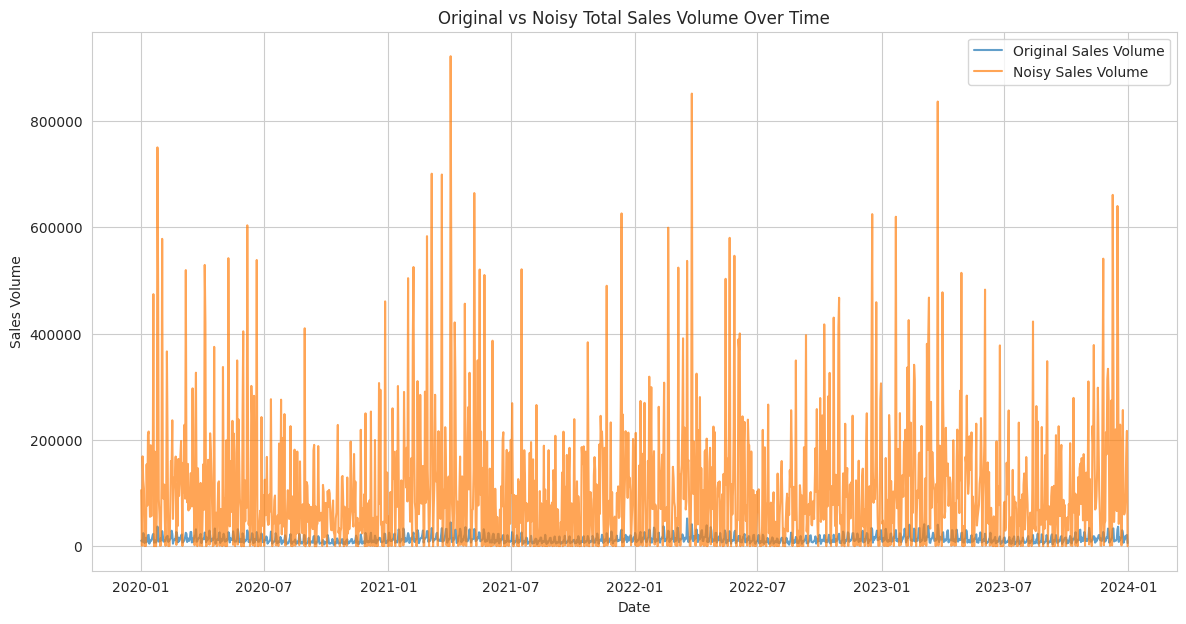

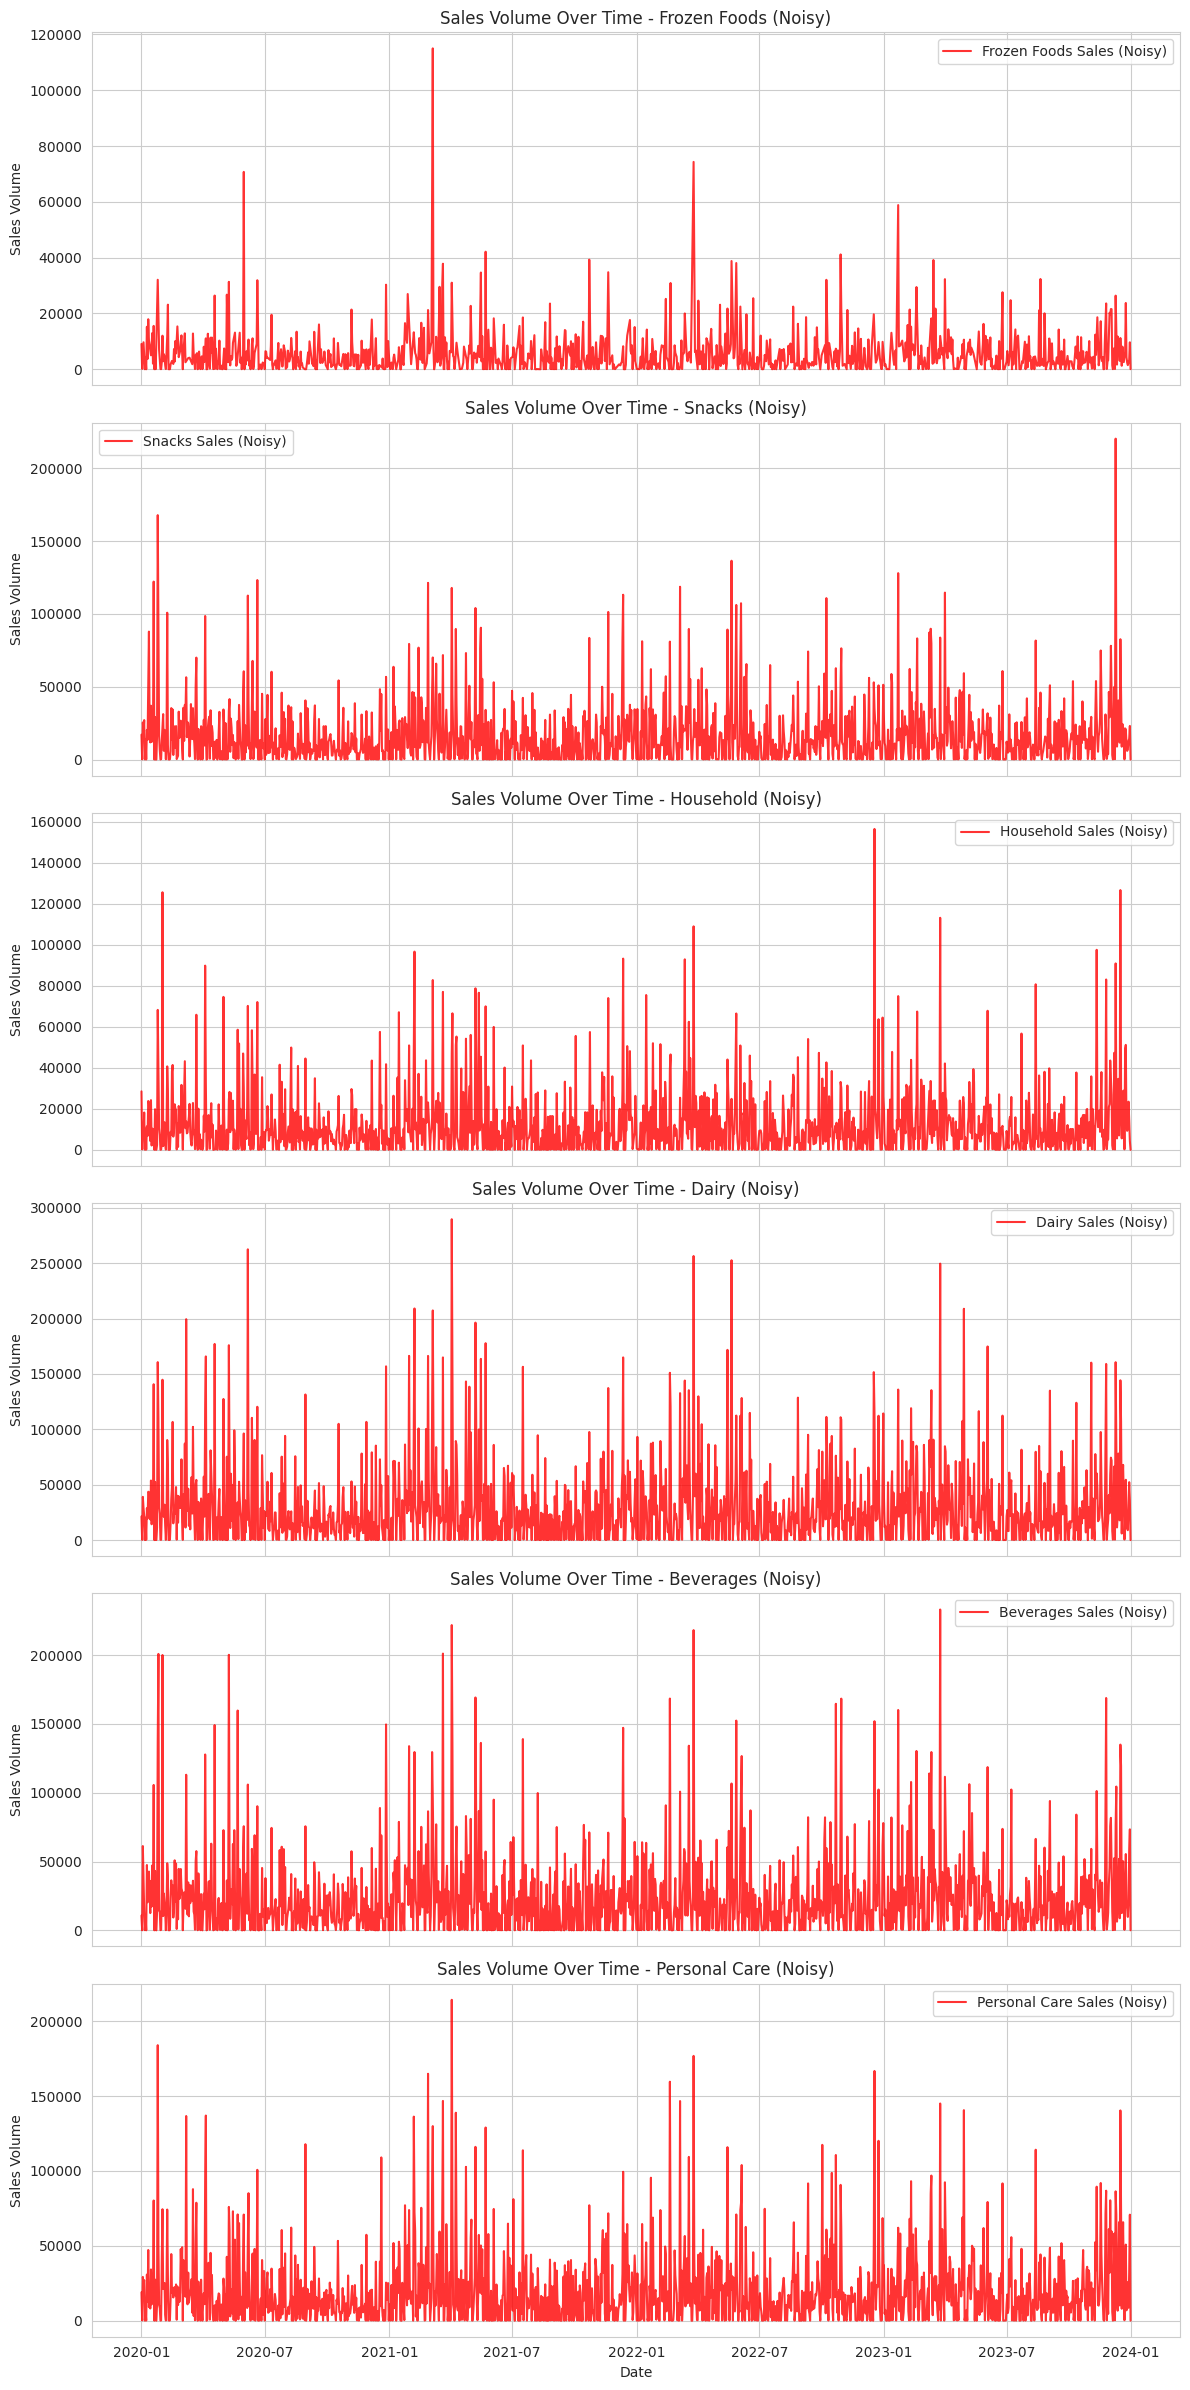


4. Sales Trend Analysis
--------------------------------------------------------------------------------

Monthly Sales Data:
         Date  Sales_Volume    Month
0  2020-01-31       4112969  2020-01
1  2020-02-29       3685337  2020-02
2  2020-03-31       3734708  2020-03
3  2020-04-30       3186128  2020-04
4  2020-05-31       4272338  2020-05
5  2020-06-30       3606884  2020-06
6  2020-07-31       2671473  2020-07
7  2020-08-31       2236382  2020-08
8  2020-09-30       2027537  2020-09
9  2020-10-31       1859885  2020-10
10 2020-11-30       2181382  2020-11
11 2020-12-31       2490019  2020-12
12 2021-01-31       3514618  2021-01
13 2021-02-28       4241395  2021-02
14 2021-03-31       4557522  2021-03
15 2021-04-30       4571053  2021-04
16 2021-05-31       4579215  2021-05
17 2021-06-30       2086217  2021-06
18 2021-07-31       3073345  2021-07
19 2021-08-31       1824761  2021-08
20 2021-09-30       2002457  2021-09
21 2021-10-31       2620649  2021-10
22 2021-11-30       31

<ipython-input-60-3765441f2eff>:264: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df_noisy.groupby(pd.Grouper(key='Date', freq='M'))['Sales_Volume'].sum().reset_index()


In [60]:
import pandas as pd
import numpy as np
import random
from datetime import datetime
import matplotlib.pyplot as plt

# --------------------------
# 1. Define Product Categories & Weights (Intensified)
# --------------------------
product_categories = {
    'Dairy': ['Milk', 'Cottage Cheese', 'Cheese', 'Curd', 'Butter', 'Yogurt'],
    'Household': ['Detergent', 'Dishwasher', 'Cleaning Cloth', 'Mop', 'Broom', 'Toilet Paper'],
    'Personal Care': ['Shampoo', 'Conditioner', 'Soap', 'Toothpaste', 'Deodorant', 'Body Lotion'],
    'Snacks': ['Chips', 'Cookies', 'Biscuits', 'Candy', 'Popcorn', 'Granola Bars'],
    'Beverages': ['Juice', 'Soda', 'Tea', 'Coffee', 'Water', 'Energy Drink'],
    'Frozen Foods': ['Ice Cream', 'Frozen Vegetables', 'Frozen Pizza', 'Frozen Meals', 'Frozen Fish']
}

# Intensified category weights (normalized)
category_weights = {'Dairy': 0.35, 'Household': 0.15, 'Personal Care': 0.25, 'Snacks': 0.20, 'Beverages': 0.30, 'Frozen Foods': 0.05}
total = sum(category_weights.values())
category_weights = {k: v / total for k, v in category_weights.items()}

# Intensified product weights within each category
product_weights = {
    'Dairy': {'Milk': 0.6, 'Cottage Cheese': 0.15, 'Cheese': 0.1, 'Curd': 0.05, 'Butter': 0.05, 'Yogurt': 0.05},
    'Household': {'Detergent': 0.5, 'Dishwasher': 0.1, 'Cleaning Cloth': 0.1, 'Mop': 0.1, 'Broom': 0.1, 'Toilet Paper': 0.1},
    'Personal Care': {'Shampoo': 0.45, 'Conditioner': 0.15, 'Soap': 0.15, 'Toothpaste': 0.1, 'Deodorant': 0.1, 'Body Lotion': 0.05},
    'Snacks': {'Chips': 0.35, 'Cookies': 0.25, 'Biscuits': 0.15, 'Candy': 0.1, 'Popcorn': 0.1, 'Granola Bars': 0.05},
    'Beverages': {'Juice': 0.35, 'Soda': 0.25, 'Tea': 0.2, 'Coffee': 0.1, 'Water': 0.05, 'Energy Drink': 0.05},
    'Frozen Foods': {'Ice Cream': 0.5, 'Frozen Vegetables': 0.2, 'Frozen Pizza': 0.15, 'Frozen Meals': 0.1, 'Frozen Fish': 0.05}
}

# Define realistic prices for each product (INR)
product_prices = {
    'Milk': 55,  # 1 liter
    'Cottage Cheese': 250,  # 200g
    'Cheese': 350,  # 200g
    'Curd': 30,  # 200g
    'Butter': 150,  # 100g
    'Yogurt': 40,  # 150g
    'Detergent': 120,  # 1 kg
    'Dishwasher': 180,  # 1 liter
    'Cleaning Cloth': 50,  # per piece
    'Mop': 300,  # per piece
    'Broom': 250,  # per piece
    'Toilet Paper': 60,  # per roll
    'Shampoo': 200,  # 180ml
    'Conditioner': 220,  # 180ml
    'Soap': 40,  # per piece
    'Toothpaste': 80,  # 100g
    'Deodorant': 150,  # 150ml
    'Body Lotion': 250,  # 250ml
    'Chips': 30,  # per pack
    'Cookies': 50,  # per pack
    'Biscuits': 40,  # per pack
    'Candy': 10,  # per piece
    'Popcorn': 60,  # per pack
    'Granola Bars': 80,  # per bar
    'Juice': 100,  # 1 liter
    'Soda': 40,  # 500ml
    'Tea': 30,  # per pack of 10
    'Coffee': 150,  # 100g
    'Water': 20,  # 1 liter
    'Energy Drink': 90,  # 250ml
    'Ice Cream': 120,  # per scoop
    'Frozen Vegetables': 180,  # 500g
    'Frozen Pizza': 300,  # per pizza
    'Frozen Meals': 250,  # per meal
    'Frozen Fish': 400  # 500g
}

# Define supplier cost ranges per category
category_supplier_cost_ranges = {
    'Dairy': (0.6, 0.8),  # 60-80% of price
    'Household': (0.5, 0.7),  # 50-70% of price
    'Personal Care': (0.4, 0.6),  # 40-60% of price
    'Snacks': (0.65, 0.85),  # 65-85% of price
    'Beverages': (0.55, 0.75),  # 55-75% of price
    'Frozen Foods': (0.7, 0.9)  # 70-90% of price
}

# --------------------------
# Define Store Locations & Weights (Intensified)
# --------------------------
store_locations = ['Hinjewadi', 'Koregaon Park', 'Magarpatta', 'Kothrud', 'Viman Nagar']
store_weights = {'Hinjewadi': 0.1, 'Koregaon Park': 0.35, 'Magarpatta': 0.15, 'Kothrud': 0.2, 'Viman Nagar': 0.2}
store_sales_multiplier = {'Hinjewadi': 0.8, 'Koregaon Park': 1.5, 'Magarpatta': 1.2, 'Kothrud': 1.0, 'Viman Nagar': 1.4}

# --------------------------
# Define Weekday-Based Sales Patterns (More Extreme)
# --------------------------
weekday_multiplier = {
    0: 0.7,    # Monday - Lower sales
    1: 1.0,    # Tuesday - Normal
    2: 1.0,    # Wednesday - Normal
    3: 1.1,    # Thursday - Slight increase
    4: 1.3,    # Friday - High demand
    5: 1.8,    # Saturday - Peak demand
    6: 1.6      # Sunday - Almost peak
}

# --------------------------
# Generate Date Range (4-year period)
# --------------------------
start_date = datetime(2020, 1, 1)
end_date = datetime(2023, 12, 31)
dates = pd.date_range(start_date, end_date, freq='D')

# --------------------------
# Define Sales Pattern for Forecasting over 4 Years with different yearly waves
# --------------------------
days_of_pattern = len(dates)
t = np.arange(days_of_pattern)
pattern_array = np.zeros(days_of_pattern)

for year in range(4):
    year_start = year * 365
    year_end = (year + 1) * 365
    if year_end > days_of_pattern:
        year_end = days_of_pattern
    year_t = np.arange(year_end - year_start)

    # Different waves for each year:
    base_level = 200 + year * 10  # Significantly reduced base level
    amplitude = 100 - year * 5    # Decreasing amplitude
    noise_std = 20 + year * 1     # Increasing noise
    frequency = 2 * np.pi * (1 + year * 0.1) / 365 # Changing the frequency

    pattern_array[year_start:year_end] = base_level + amplitude * np.sin(frequency * year_t) + np.random.normal(0, noise_std, len(year_t))

# Use the entire 4-year pattern as our forecast pattern
pattern_window = pattern_array

# --------------------------
# Generate Synthetic Data with Enhanced Imbalance, Noise, and Outliers
# --------------------------
def generate_synthetic_data(pattern, dates, product_categories, category_weights, product_weights, store_weights, store_sales_multiplier, weekday_multiplier, product_prices, category_supplier_cost_ranges, num_rows=50000, pattern_influence=0.7):
    data = []
    num_days = len(pattern)

    for _ in range(num_rows):
        date = random.choice(dates)
        day_index = (date - dates[0]).days % num_days
        weekday = date.weekday()
        store_location = random.choices(store_locations, weights=[store_weights[loc] for loc in store_locations], k=1)[0]
        categories = list(product_categories.keys())
        category = random.choices(categories, weights=[category_weights[c] for c in categories], k=1)[0]
        product = random.choices(product_categories[category], weights=[product_weights[category][p] for p in product_categories[category]], k=1)[0]
        pattern_value = pattern[day_index] if day_index < num_days else np.mean(pattern)
        trend_factor = np.sin((day_index / num_days) * np.pi)
        sales_volume = int(pattern_influence * pattern_value + (1 - pattern_influence) * (np.mean(pattern) + trend_factor * np.std(pattern) + np.random.normal(0, np.std(pattern))))
        sales_volume *= store_sales_multiplier[store_location] * weekday_multiplier[weekday]
        sales_volume = max(0, int(sales_volume))
        category_noise = np.random.uniform(0.9, 1.1)
        sales_volume = int(sales_volume * category_noise)
        if store_location == 'Koregaon Park' and weekday in [5, 6]:
            sales_volume = int(sales_volume * random.uniform(1.5, 2.0))
        price = product_prices[product]
        cost_min, cost_max = category_supplier_cost_ranges[category]
        supplier_cost = np.random.uniform(cost_min * price, cost_max * price)
        promotion = np.random.choice([0, 1], p=[0.8, 0.2])
        replenishment_lead_time = np.random.randint(1, 7)
        stock_level = np.random.randint(100, 500)
        data.append([date, category, product, sales_volume, price, promotion, store_location, weekday, supplier_cost, replenishment_lead_time, stock_level])
    df_generated = pd.DataFrame(data, columns=['Date', 'Product_Category', 'Product_Name', 'Sales_Volume', 'Price', 'Promotion', 'Store_Location', 'Weekday', 'Supplier_Cost', 'Replenishment_Lead_Time', 'Stock_Level'])
    return df_generated.sort_values(by='Date').reset_index(drop=True)

# --------------------------
# Introduce Noise and Outliers
# --------------------------
def introduce_noise_and_outliers(df, noise_factor=0.05, outlier_prob=0.03, seasonal_noise_factor=0.02, trend_noise_factor=0.01):
    df_noisy = df.copy()
    num_rows = len(df_noisy)

    # Add noise to Price
    for category in df['Product_Category'].unique():
        category_mask = df_noisy['Product_Category'] == category
        df_noisy.loc[category_mask, 'Price'] = df_noisy.loc[category_mask, 'Price'] * (1 + np.random.normal(0, noise_factor, category_mask.sum()))

    # Introduce outliers in Sales_Volume
    num_unique_dates = len(df_noisy.index.unique())
    num_outliers = min(int(outlier_prob * num_rows), num_unique_dates)
    if num_outliers > 0:
        outlier_dates = np.random.choice(df_noisy.index.unique(), num_outliers, replace=False)
        outlier_sales_multipliers = np.random.choice([5, 10, 0.1, 20, 0.05], num_outliers, p=[0.3, 0.3, 0.15, 0.15, 0.1])

        for date, multiplier in zip(outlier_dates, outlier_sales_multipliers):
            date_mask = df_noisy.index == date
            df_noisy.loc[date_mask, 'Sales_Volume'] = (df_noisy.loc[date_mask, 'Sales_Volume'] * multiplier).round().astype(int)

    # Add seasonal noise (example - adjust as needed)
    df_noisy['Sales_Volume'] = df_noisy['Sales_Volume'] * (1 + seasonal_noise_factor * np.sin(2 * np.pi * df_noisy.index.dayofyear / 365))

    # Add trend noise (example - adjust as needed)
    trend_component = 1 + trend_noise_factor * (np.arange(len(df_noisy)) / len(df_noisy))
    df_noisy['Sales_Volume'] = (df_noisy['Sales_Volume'] * trend_component).round().astype(int)

    return df_noisy
# --------------------------
# Generate & Visualize the Synthetic Data
# --------------------------
df_synthetic = generate_synthetic_data(pattern_window, dates, product_categories, category_weights, product_weights, store_weights, store_sales_multiplier, weekday_multiplier, product_prices, category_supplier_cost_ranges, num_rows=50000, pattern_influence=0.7)

print("First few rows of the synthetic data:")
print(df_synthetic.head())
print(f"Total number of rows: {len(df_synthetic)}")

plt.figure(figsize=(12, 6))
df_synthetic.groupby('Date')['Sales_Volume'].sum().plot(title="Total Synthetic Sales Volume Over 4 Years")
plt.xlabel("Date")
plt.ylabel("Sales Volume")
plt.show()

# Set 'Date' as index for noise and outlier introduction
df_synthetic = df_synthetic.set_index('Date')

# Call the function that caused the error
df_noisy = introduce_noise_and_outliers(df_synthetic)

# Reset index for plotting
df_noisy = df_noisy.reset_index()

# --------------------------
# Plot original vs noisy data
# --------------------------
plt.figure(figsize=(14, 7))
original_sales = df_synthetic.groupby(df_synthetic.index)['Sales_Volume'].sum()
noisy_sales = df_noisy.groupby('Date')['Sales_Volume'].sum()
plt.plot(original_sales.index, original_sales.values, label='Original Sales Volume', alpha=0.7)
plt.plot(noisy_sales.index, noisy_sales.values, label='Noisy Sales Volume', alpha=0.7)
plt.title('Original vs Noisy Total Sales Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.legend()
plt.show()

# --------------------------
# Visualize Per-Category Sales Trends (Noisy Data)
# --------------------------
categories = df_noisy['Product_Category'].unique()
fig, axes = plt.subplots(len(categories), 1, figsize=(12, 4 * len(categories)), sharex=True)
for i, cat in enumerate(categories):
    ax = axes[i]
    cat_data = df_noisy[df_noisy['Product_Category'] == cat].groupby('Date')['Sales_Volume'].sum()
    ax.plot(cat_data.index, cat_data.values, label=f"{cat} Sales (Noisy)", alpha=0.8, color='r')
    ax.set_title(f"Sales Volume Over Time - {cat} (Noisy)")
    ax.set_ylabel("Sales Volume")
    ax.legend()
plt.xlabel("Date")
plt.tight_layout()
plt.show()

# --------------------------
# Sales Trend Analysis (with adjusted Sales Volume)
# --------------------------
print("\n4. Sales Trend Analysis")
print("--------------------------------------------------------------------------------")

# Convert 'Date' to datetime if it's not already
df_noisy['Date'] = pd.to_datetime(df_noisy['Date'])

# Monthly Sales
monthly_sales = df_noisy.groupby(pd.Grouper(key='Date', freq='M'))['Sales_Volume'].sum().reset_index()
monthly_sales['Month'] = monthly_sales['Date'].dt.to_period('M')
print("\nMonthly Sales Data:")
print(monthly_sales)

# Weekly Sales
weekly_sales = df_noisy.groupby(pd.Grouper(key='Date', freq='W'))['Sales_Volume'].sum().reset_index()
weekly_sales['Week'] = weekly_sales['Date'].dt.isocalendar().week.astype(str).str.zfill(2)
weekly_sales['Year'] = weekly_sales['Date'].dt.year
weekly_sales['Week'] = weekly_sales['Year'].astype(str) + '-W' + weekly_sales['Week']
print("\nWeekly Sales Data:")
print(weekly_sales)

# Daily Sales by Weekday
daily_sales = df_noisy.groupby(df_noisy['Date'].dt.day_name())['Sales_Volume'].sum().sort_values(ascending=False).reset_index()
print("\nDaily Sales Data:")
print(daily_sales)

In [61]:
df = df_synthetic



Exploratory Data Analysis Report

1. Descriptive Statistics
--------------------------------------------------------------------------------
       Sales_Volume         Price  Supplier_Cost  Replenishment_Lead_Time   Stock_Level
count  50000.000000  50000.000000   50000.000000             50000.000000  50000.000000
mean    3136.019880    109.247326      68.654484                 3.498100    299.517620
std     3918.739921     85.429797      55.167643                 1.710174    115.515945
min        3.000000      8.454007       6.503926                 1.000000    100.000000
25%      130.000000     42.394466      29.551496                 2.000000    200.000000
50%     2097.000000     63.050784      43.347519                 4.000000    299.000000
75%     4195.000000    161.318253      93.549951                 5.000000    400.000000
max    39608.000000    440.026767     359.233022                 6.000000    499.000000


2. Categorical Variable Distribution
--------------------------

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


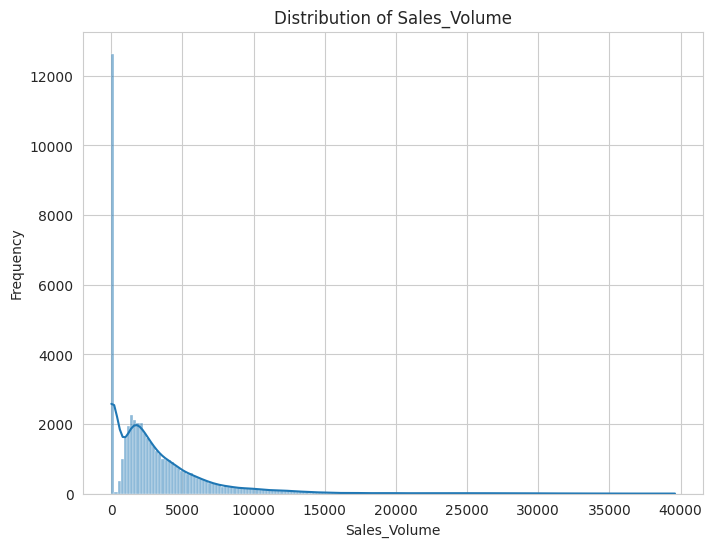

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


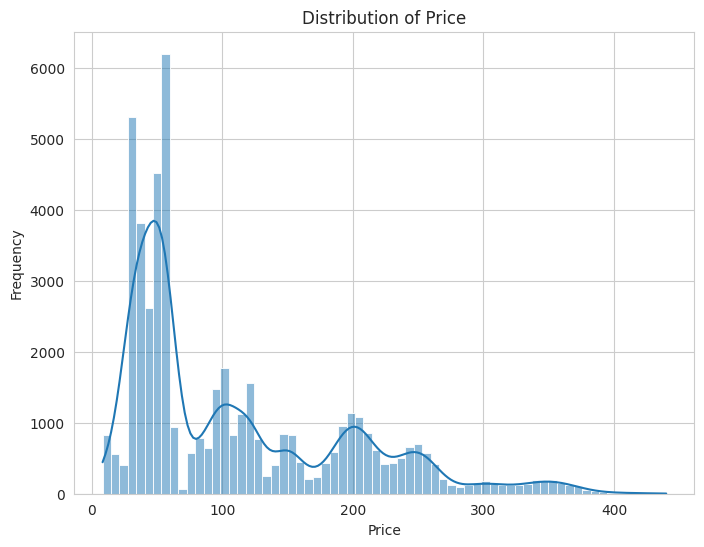

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


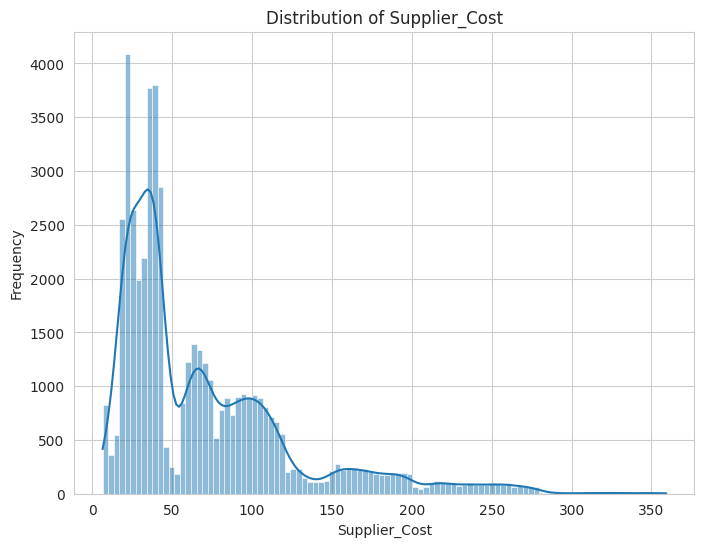

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


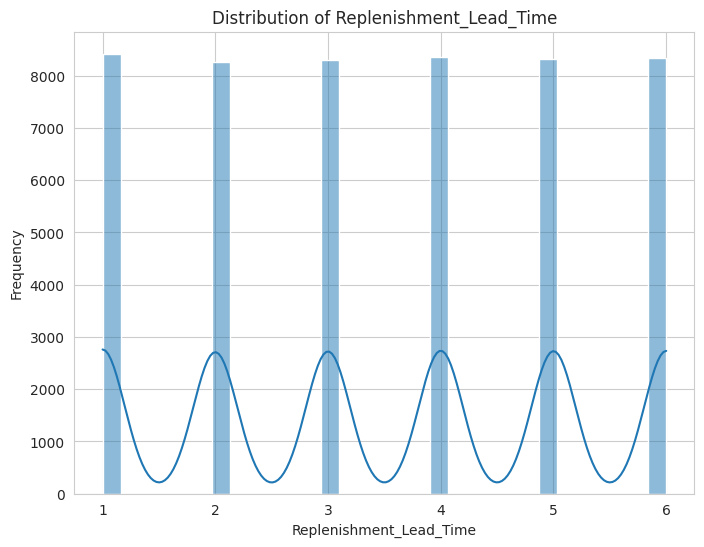

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


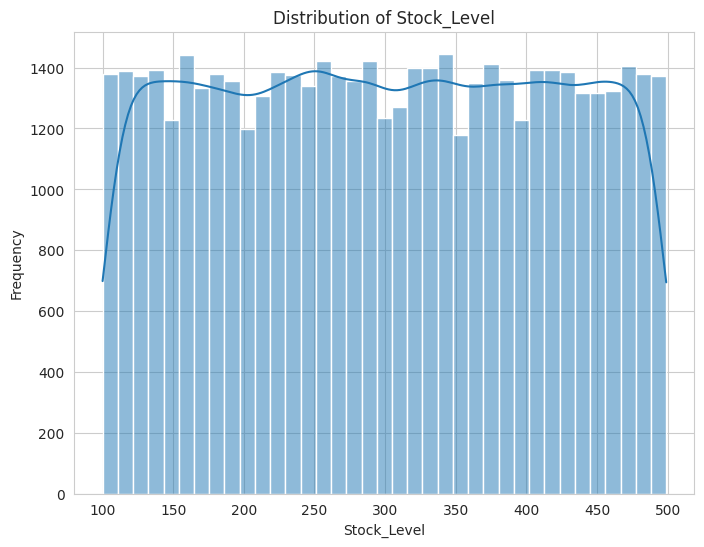

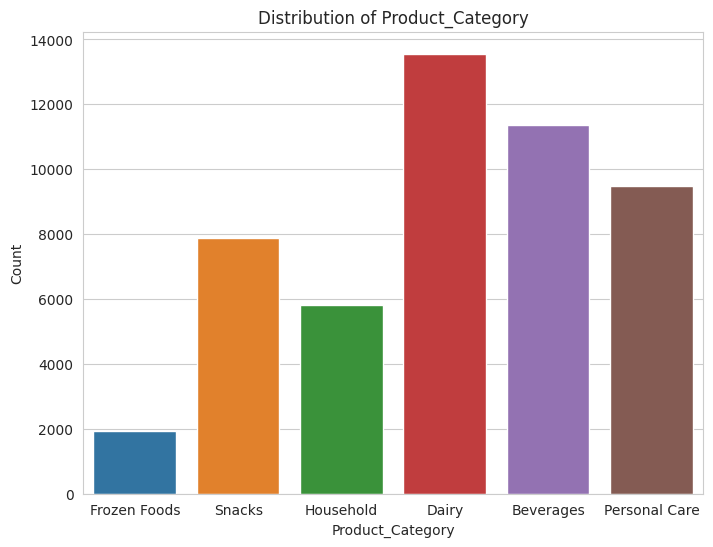

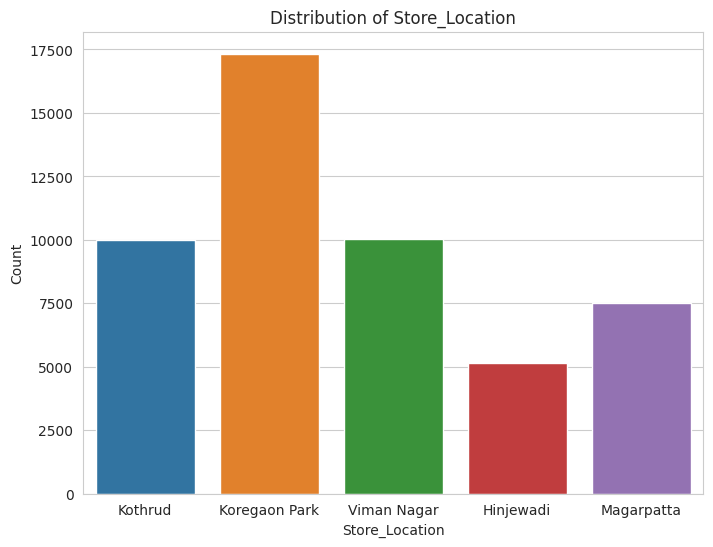

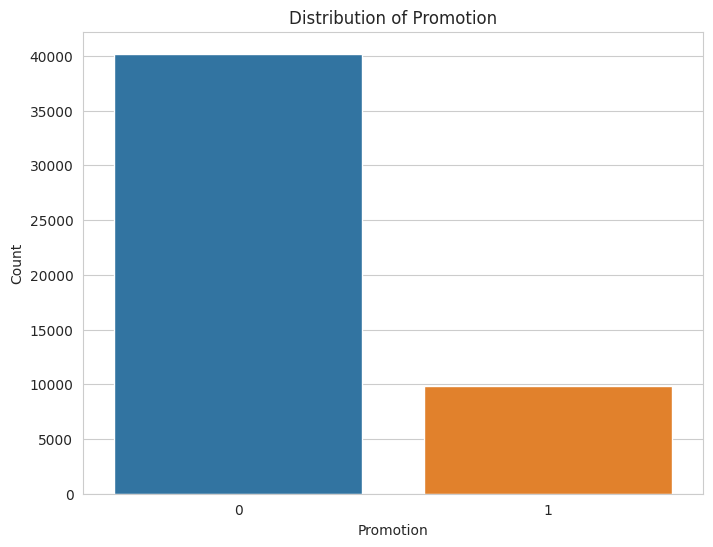

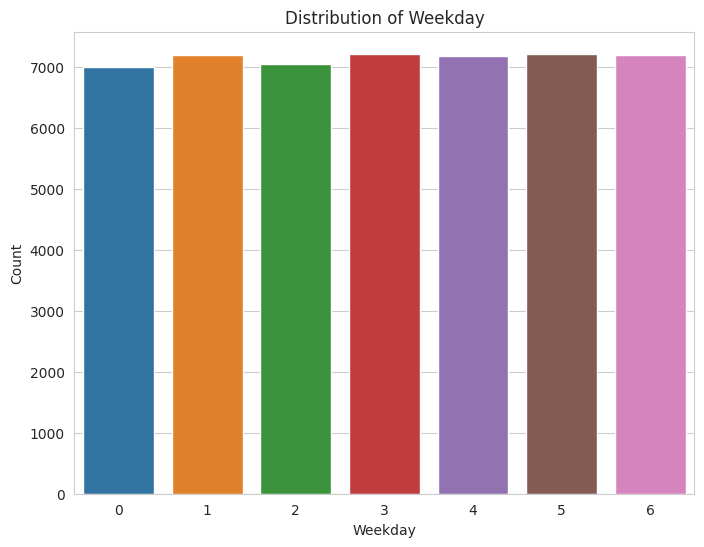



4. Sales Trend Analysis
--------------------------------------------------------------------------------
Monthly Sales Data:
        Date  Sales_Volume    Month
0 2020-01-31       4112969  2020-01
1 2020-02-29       3685337  2020-02
2 2020-03-31       3734708  2020-03
3 2020-04-30       3186128  2020-04
4 2020-05-31       4272338  2020-05

Weekly Sales Data:
        Date  Sales_Volume      Week
0 2020-01-05        509656  2020-W01
1 2020-01-12        723808  2020-W02
2 2020-01-19       1137687  2020-W03
3 2020-01-26       1475793  2020-W04
4 2020-02-02        945151  2020-W05

Daily Sales Data:
        Date  Sales_Volume
2   Saturday      41485127
3     Sunday      33583788
0     Friday      21913538
4   Thursday      18361088
6  Wednesday      15660695


<ipython-input-62-ef4a68fc3e0d>:73: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.groupby(pd.Grouper(key=date_col, freq='M'))[sales_col].sum().reset_index()
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


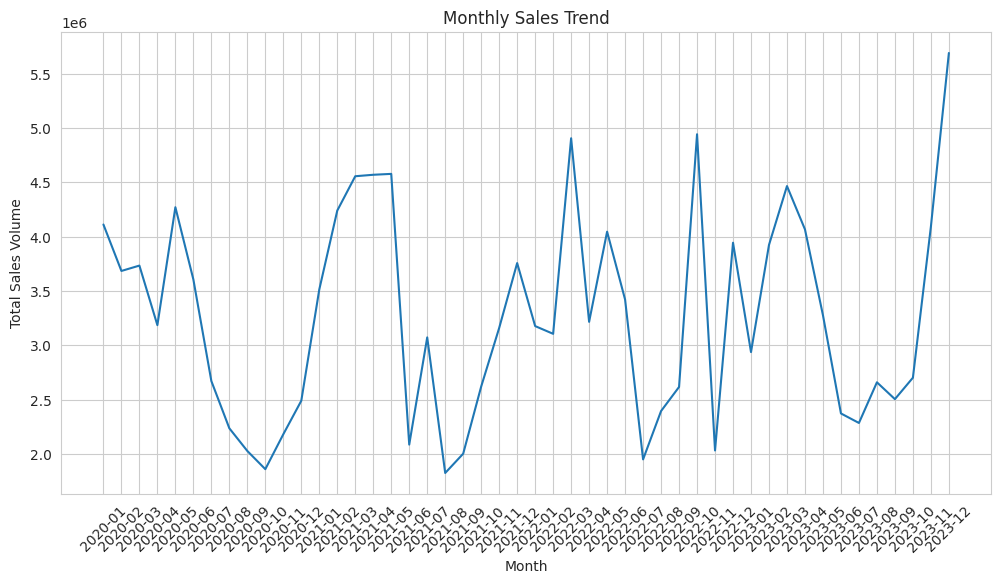

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


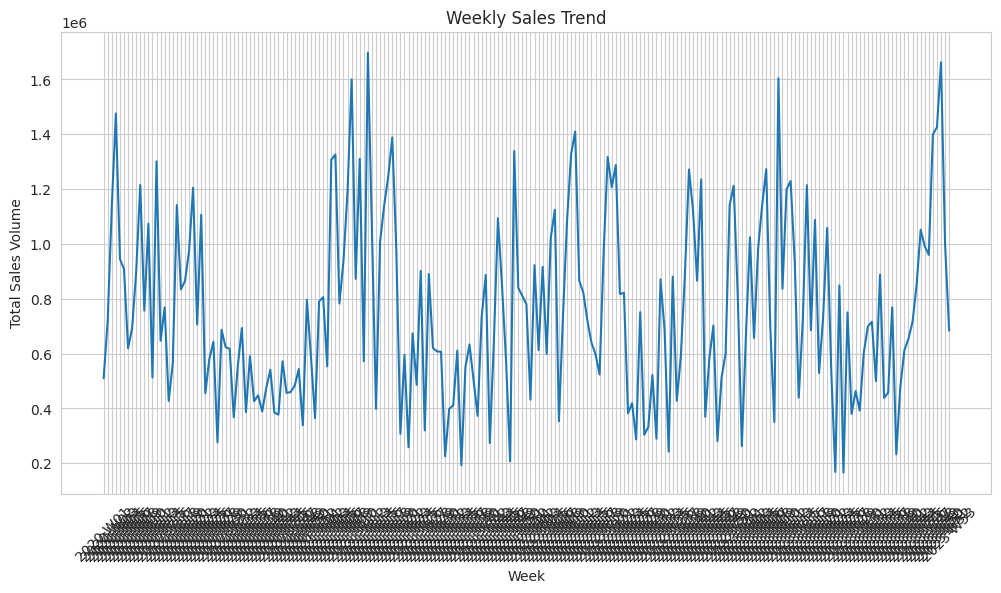

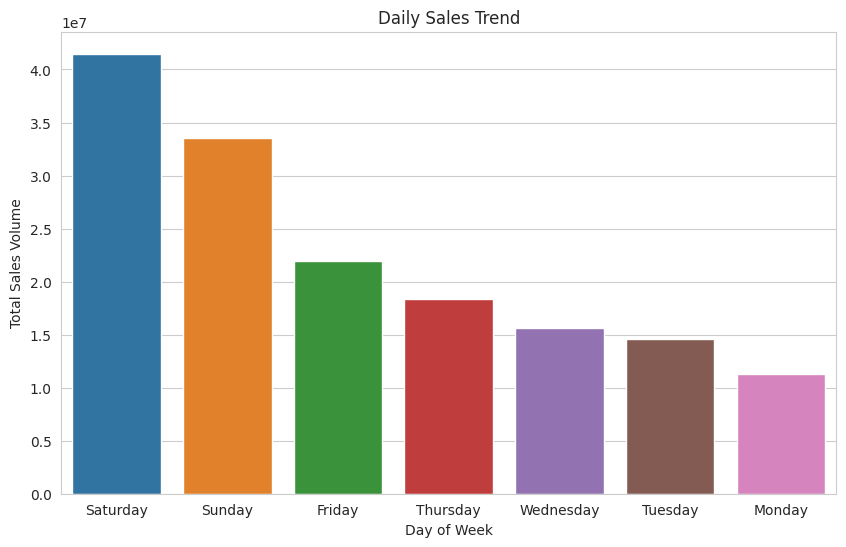



5. Store Trend Analysis
--------------------------------------------------------------------------------
Store-wise Monthly Sales Data:
  Store_Location       Date  Sales_Volume    Month
0      Hinjewadi 2020-01-31        174213  2020-01
1      Hinjewadi 2020-02-29        210827  2020-02
2      Hinjewadi 2020-03-31        236261  2020-03
3      Hinjewadi 2020-04-30        158909  2020-04
4      Hinjewadi 2020-05-31        213399  2020-05


<ipython-input-62-ef4a68fc3e0d>:130: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  store_sales = df.groupby([store_col, pd.Grouper(key=date_col, freq='M')])[sales_col].sum().reset_index()
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of 

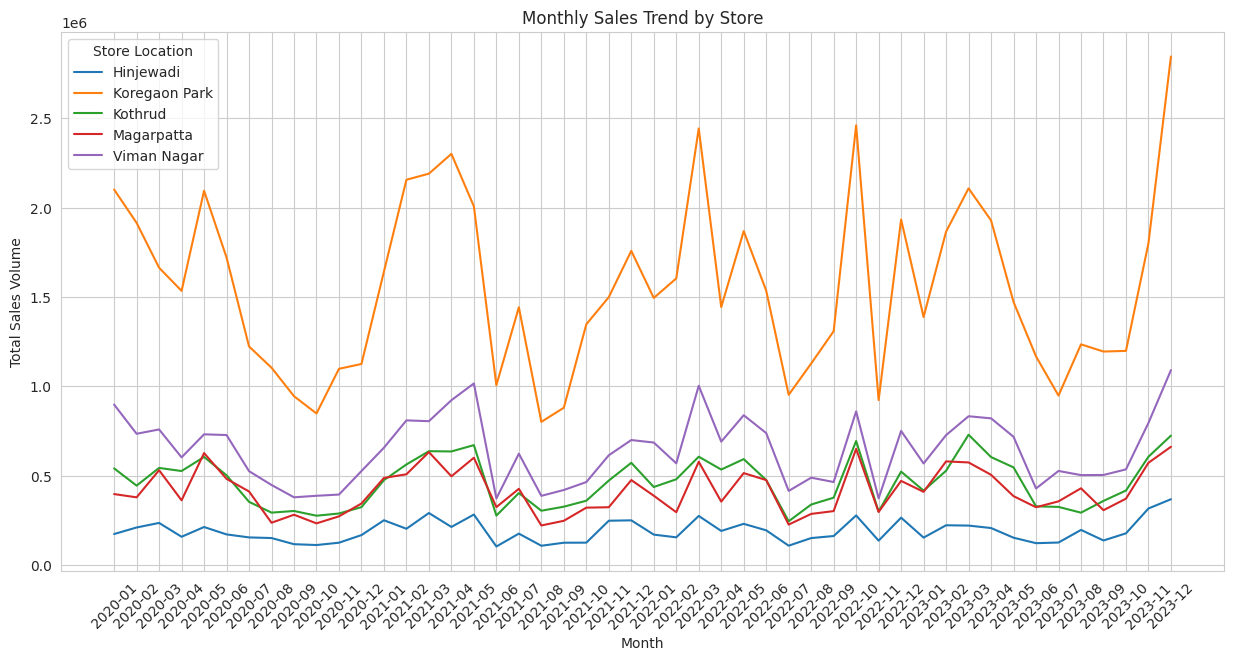



6. Category Trend Analysis
--------------------------------------------------------------------------------

Category-wise Monthly Sales Data:
  Product_Category       Date  Sales_Volume    Month
0        Beverages 2020-01-31        993939  2020-01
1        Beverages 2020-02-29        843866  2020-02
2        Beverages 2020-03-31        772150  2020-03
3        Beverages 2020-04-30        685659  2020-04
4        Beverages 2020-05-31       1074108  2020-05


<ipython-input-62-ef4a68fc3e0d>:158: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  category_sales = df.groupby([category_col, pd.Grouper(key=date_col, freq='M')])[sales_col].sum().reset_index()
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` inste

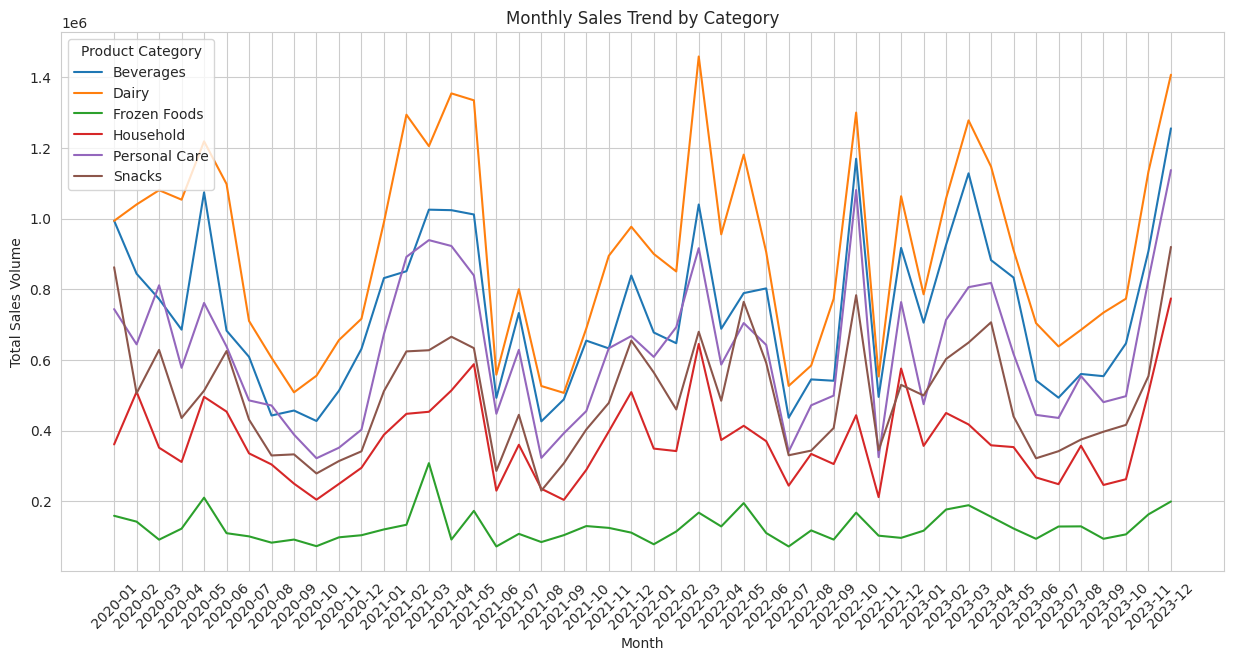



7. Correlation Analysis
--------------------------------------------------------------------------------


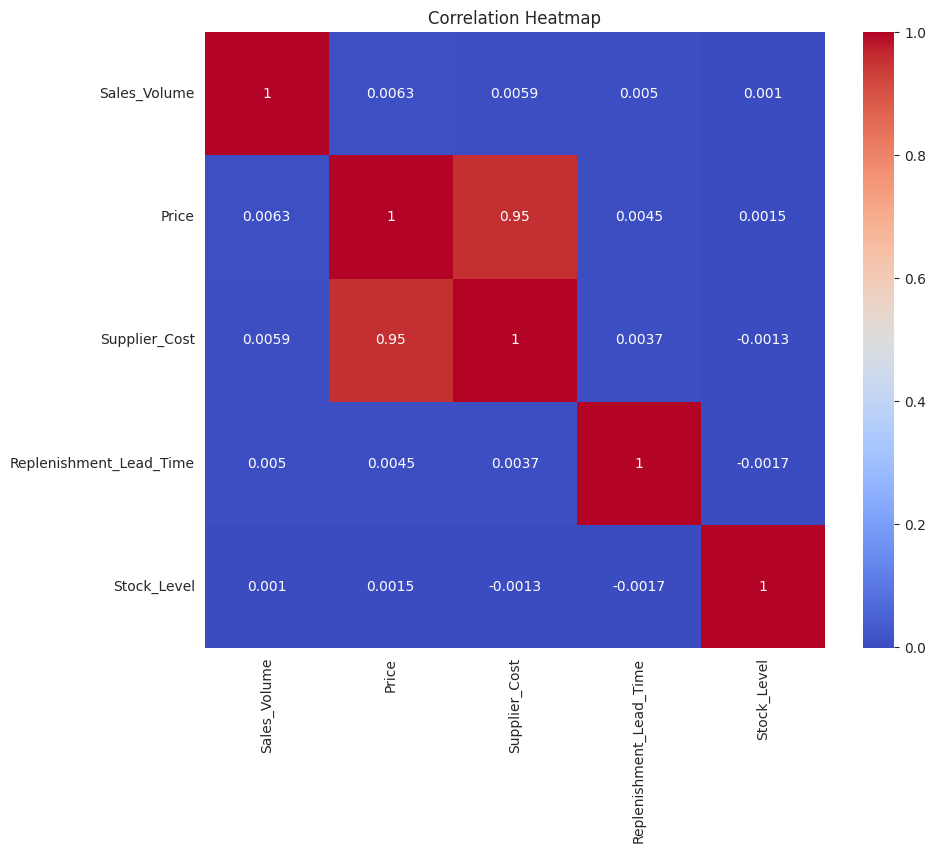



8. Anomaly Detection
--------------------------------------------------------------------------------

Anomalies Detected:
            Date Product_Category    Product_Name  Sales_Volume       Price  \
664   2020-01-19            Dairy            Milk         25325   52.337835   
668   2020-01-19    Personal Care         Shampoo         21399  211.892438   
669   2020-01-19           Snacks         Popcorn         21923   56.566152   
670   2020-01-19        Beverages             Tea         22668   31.196250   
671   2020-01-19            Dairy          Butter         17756  146.950554   
...          ...              ...             ...           ...         ...   
49450 2023-12-16        Household  Cleaning Cloth         26907   52.348613   
49451 2023-12-16        Beverages           Juice         28333   98.228942   
49453 2023-12-16           Snacks         Cookies         35105   49.435320   
49456 2023-12-16    Personal Care     Body Lotion         29599  242.041822   
49950 

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


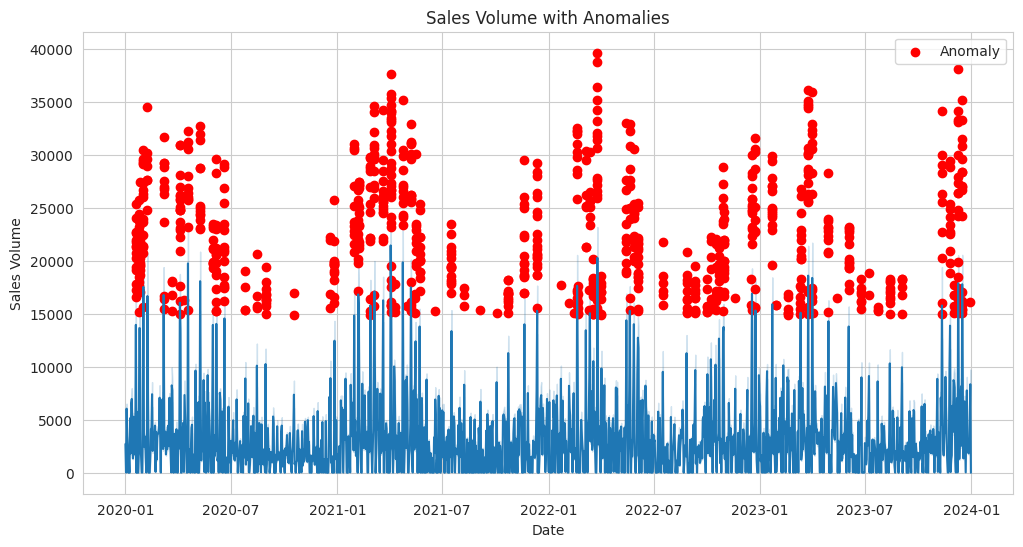



End of EDA Report


In [62]:
# 2. Enhanced Exploratory Data Analysis Functions

def get_descriptive_statistics(df, numerical_cols):
    """
    Generates descriptive statistics for numerical columns.

    Args:
        df (pd.DataFrame): The input DataFrame.
        numerical_cols (list): List of numerical columns.

    Returns:
        pd.DataFrame: Descriptive statistics.
    """
    return df[numerical_cols].describe()

def analyze_categorical_distribution(df, categorical_cols):
    """
    Analyzes the distribution of categorical variables.

    Args:
        df (pd.DataFrame): The input DataFrame.
        categorical_cols (list): List of categorical columns.

    Returns:
        dict: A dictionary containing value counts for each categorical column.
    """
    distributions = {}
    for col in categorical_cols:
        distributions[col] = df[col].value_counts()
    return distributions

def visualize_distribution(df, numerical_cols, categorical_cols):
    """
    Visualizes the distribution of numerical and categorical variables.

    Args:
        df (pd.DataFrame): The input DataFrame.
        numerical_cols (list): List of numerical columns.
        categorical_cols (list): List of categorical columns.
    """
    for col in numerical_cols:
        plt.figure(figsize=(8, 6))
        sns.histplot(df[col], kde=True)  # Use seaborn for better plots
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

    for col in categorical_cols:
        plt.figure(figsize=(8, 6))
        sns.countplot(x=col, data=df)  # Use seaborn countplot
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.show()

def analyze_sales_trends(df, date_col='Date', sales_col='Sales_Volume'):
    """
    Analyzes sales trends over time, including monthly and weekly trends.

    Args:
        df (pd.DataFrame): The input DataFrame.
        date_col (str): The name of the date column.
        sales_col (str): The name of the sales volume column.

    Returns:
        pd.DataFrame: DataFrame with aggregated sales data.
    """
    # Ensure the date column is correctly set.
    df[date_col] = pd.to_datetime(df[date_col])

    # Aggregate sales by month
    monthly_sales = df.groupby(pd.Grouper(key=date_col, freq='M'))[sales_col].sum().reset_index()
    monthly_sales['Month'] = monthly_sales[date_col].dt.strftime('%Y-%m')

    # Aggregate sales by week
    weekly_sales = df.groupby(pd.Grouper(key=date_col, freq='W'))[sales_col].sum().reset_index()
    weekly_sales['Week'] = weekly_sales[date_col].dt.strftime('%Y-W%U')

    # Aggregate sales by day of week
    daily_sales = df.groupby(df[date_col].dt.day_name())[sales_col].sum().reset_index()
    daily_sales = daily_sales.sort_values(by=sales_col, ascending=False)  # Sort by sales

    # Print the first few rows of the aggregated dataframes
    print("Monthly Sales Data:")
    print(monthly_sales.head())
    print("\nWeekly Sales Data:")
    print(weekly_sales.head())
    print("\nDaily Sales Data:")
    print(daily_sales.head())

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Month', y=sales_col, data=monthly_sales)
    plt.title('Monthly Sales Trend')
    plt.xlabel('Month')
    plt.ylabel('Total Sales Volume')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Week', y=sales_col, data=weekly_sales)
    plt.title('Weekly Sales Trend')
    plt.xlabel('Week')
    plt.ylabel('Total Sales Volume')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=date_col, y=sales_col, data=daily_sales)
    plt.title('Daily Sales Trend')
    plt.xlabel('Day of Week')
    plt.ylabel('Total Sales Volume')
    plt.show()

    return monthly_sales, weekly_sales, daily_sales # Return the dataframes

def analyze_store_trends(df, store_col='Store_Location', sales_col='Sales_Volume', date_col='Date'):
    """
    Analyzes sales trends for each store.

    Args:
        df (pd.DataFrame): The input DataFrame.
        store_col (str): The name of the store location column.
        sales_col (str): The name of the sales volume column.
        date_col (str): The name of the date column.
    """
    # Ensure the date column is correctly set.
    df[date_col] = pd.to_datetime(df[date_col])
    store_sales = df.groupby([store_col, pd.Grouper(key=date_col, freq='M')])[sales_col].sum().reset_index()
    store_sales['Month'] = store_sales[date_col].dt.strftime('%Y-%m')

    # Print first few rows
    print("Store-wise Monthly Sales Data:")
    print(store_sales.head())

    plt.figure(figsize=(15, 7))
    sns.lineplot(x='Month', y=sales_col, hue=store_col, data=store_sales)
    plt.title('Monthly Sales Trend by Store')
    plt.xlabel('Month')
    plt.ylabel('Total Sales Volume')
    plt.xticks(rotation=45)
    plt.legend(title='Store Location')
    plt.show()

def analyze_category_trends(df, category_col='Product_Category', sales_col='Sales_Volume', date_col='Date'):
    """
    Analyzes sales trends for each product category.

    Args:
        df (pd.DataFrame): The input DataFrame.
        category_col (str): The name of the product category column.
        sales_col (str): The name of the sales volume column.
        date_col (str): The name of the date column.
    """
    # Ensure the date column is correctly set.
    df[date_col] = pd.to_datetime(df[date_col])
    category_sales = df.groupby([category_col, pd.Grouper(key=date_col, freq='M')])[sales_col].sum().reset_index()
    category_sales['Month'] = category_sales[date_col].dt.strftime('%Y-%m')

    # Print first few rows
    print("\nCategory-wise Monthly Sales Data:")
    print(category_sales.head())

    plt.figure(figsize=(15, 7))
    sns.lineplot(x='Month', y=sales_col, hue=category_col, data=category_sales)
    plt.title('Monthly Sales Trend by Category')
    plt.xlabel('Month')
    plt.ylabel('Total Sales Volume')
    plt.xticks(rotation=45)
    plt.legend(title='Product Category')
    plt.show()

def analyze_correlations(df, numerical_cols):
    """
    Analyzes correlations between numerical variables using a heatmap.

    Args:
        df (pd.DataFrame): The input DataFrame.
        numerical_cols (list): List of numerical columns.
    """
    correlation_matrix = df[numerical_cols].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

def detect_anomalies(df, sales_col='Sales_Volume', date_col='Date', threshold=3):
    """
    Detects anomalies in sales data using z-score.

    Args:
        df (pd.DataFrame): The input DataFrame.
        sales_col (str): The name of the sales volume column.
        date_col (str): The name of the date column.
        threshold (float): Z-score threshold for anomaly detection.
    Returns:
      pd.DataFrame: DataFrame containing the anomalies
    """
    df_copy = df.copy()
    z_scores = np.abs((df_copy[sales_col] - df_copy[sales_col].mean()) / df_copy[sales_col].std())
    anomalies = df_copy[z_scores > threshold]

    print("\nAnomalies Detected:")
    print(anomalies)

    if not anomalies.empty:
        plt.figure(figsize=(12, 6))
        sns.lineplot(x=date_col, y=sales_col, data=df_copy)
        plt.scatter(anomalies[date_col], anomalies[sales_col], color='red', label='Anomaly')
        plt.title('Sales Volume with Anomalies')
        plt.xlabel('Date')
        plt.ylabel('Sales Volume')
        plt.legend()
        plt.show()
    return anomalies

def generate_eda_report(df, numerical_cols, categorical_cols):
    """
    Generates a comprehensive EDA report.

    Args:
        df (pd.DataFrame): The input DataFrame.
        numerical_cols (list): List of numerical columns.
        categorical_cols (list): List of categorical columns.
    """
    print("\n\nExploratory Data Analysis Report\n" + "="*80)

    print("\n1. Descriptive Statistics\n" + "-"*80)
    print(get_descriptive_statistics(df, numerical_cols).to_string())

    print("\n\n2. Categorical Variable Distribution\n" + "-"*80)
    distributions = analyze_categorical_distribution(df, categorical_cols)
    for col, distribution in distributions.items():
        print(f"\nColumn: {col}\n{distribution.to_string()}\n")

    print("\n\n3. Data Distribution Visualization\n" + "-"*80)
    visualize_distribution(df, numerical_cols, categorical_cols)

    print("\n\n4. Sales Trend Analysis\n" + "-"*80)
    monthly_sales, weekly_sales, daily_sales = analyze_sales_trends(df) # Capture returned DataFrames.

    print("\n\n5. Store Trend Analysis\n" + "-"*80)
    analyze_store_trends(df)

    print("\n\n6. Category Trend Analysis\n" + "-"*80)
    analyze_category_trends(df)

    print("\n\n7. Correlation Analysis\n" + "-"*80)
    analyze_correlations(df, numerical_cols)

    print("\n\n8. Anomaly Detection\n" + "-"*80)
    detect_anomalies(df)

    print("\n\nEnd of EDA Report\n" + "="*80)

# Example usage:
numerical_cols = ['Sales_Volume', 'Price', 'Supplier_Cost', 'Replenishment_Lead_Time', 'Stock_Level']
categorical_cols = ['Product_Category', 'Store_Location', 'Promotion', 'Weekday'] # Removed Product_Name which has too many unique values
generate_eda_report(df_noisy, numerical_cols, categorical_cols)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0667 - val_loss: 0.0439
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0261 - val_loss: 0.0419
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0263 - val_loss: 0.0427
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0249 - val_loss: 0.0414
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0263 - val_loss: 0.0417
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0262 - val_loss: 0.0416
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0244 - val_loss: 0.0399
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0261 - val_loss: 0.0394
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0253 - val_loss: 0.0387
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0233 - val_loss: 0.0378
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0239 - val_loss: 0.0373
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0

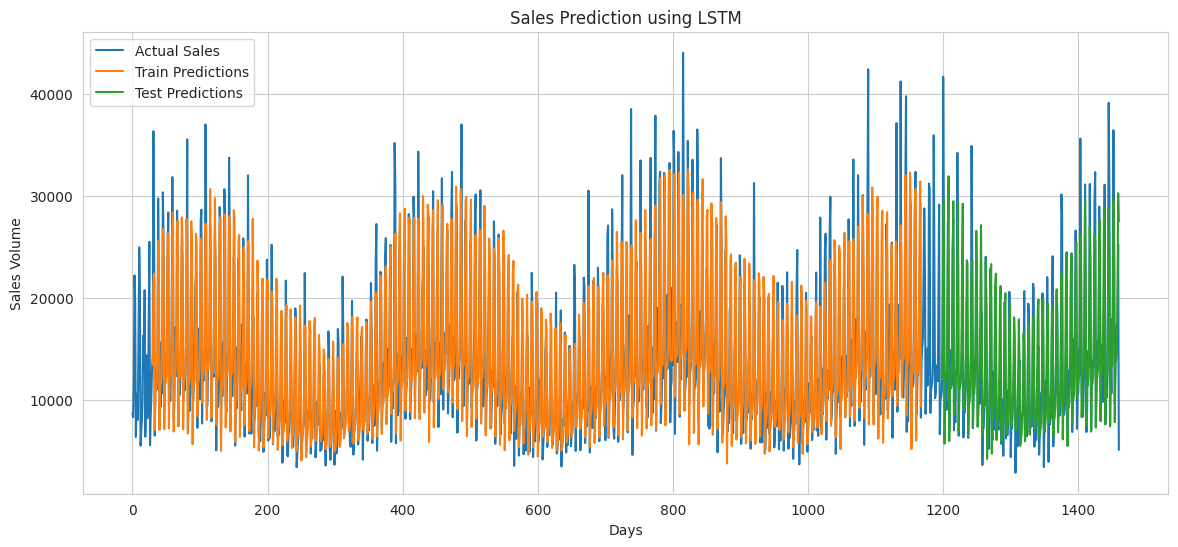

In [63]:
import pandas as pd
import numpy as np
import random
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping

# ... (Previous code for data generation remains the same) ...

# --------------------------
# Generate & Visualize the Synthetic Data
# --------------------------
df_synthetic = generate_synthetic_data(pattern_window, dates, product_categories, category_weights, product_weights, store_weights, store_sales_multiplier, weekday_multiplier, product_prices, category_supplier_cost_ranges, num_rows=50000, pattern_influence=0.7)

# Preprocessing for LSTM
series = df_synthetic.groupby('Date')['Sales_Volume'].sum().values.reshape(-1, 1)

#Check for Nan values and handle them.
if(np.isnan(series).any()):
    print("Nan Values detected, filling with zero")
    series = np.nan_to_num(series)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_series = scaler.fit_transform(series)

# Function to create dataset with lookback
def create_dataset(dataset, look_back=30):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 30
train_size = int(len(scaled_series) * 0.8)
test_size = len(scaled_series) - train_size
train, test = scaled_series[0:train_size, :], scaled_series[train_size:len(scaled_series), :]
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# LSTM Model
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(trainX, trainY, epochs=100, batch_size=64, verbose=1, validation_split=0.1, callbacks=[early_stopping])

# Predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Inverse transform predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY.reshape(-1, 1))

# Metrics
trainScoreRMSE = np.sqrt(mean_squared_error(trainY, trainPredict))
testScoreRMSE = np.sqrt(mean_squared_error(testY, testPredict))
trainScoreMAE = mean_absolute_error(trainY, trainPredict)
testScoreMAE = mean_absolute_error(testY, testPredict)

print('Train RMSE: %.2f RMSE' % (trainScoreRMSE))
print('Test RMSE: %.2f RMSE' % (testScoreRMSE))
print('Train MAE: %.2f MAE' % (trainScoreMAE))
print('Test MAE: %.2f MAE' % (testScoreMAE))

# Visualization
trainPredictPlot = np.empty_like(series, dtype=float) #explicitly set dtype to float
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

testPredictPlot = np.empty_like(series, dtype=float) #explicitly set dtype to float
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2):len(series), :] = testPredict

plt.figure(figsize=(14, 6))
plt.plot(series, label='Actual Sales')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')
plt.xlabel('Days')
plt.ylabel('Sales Volume')
plt.title('Sales Prediction using LSTM')
plt.legend()
plt.show()